# **Prepare the execution file**

In [0]:
#Clone this Github folder and rename it by Agri (you can give the name you want)

In [0]:
!git clone https://github.com/crowdai/crowdai-mapping-challenge-mask-rcnn Agri

In [0]:
#These commands will help you navigate through the folder 
# "cd Agri" : Enter to Agri folder
# "!pwd" : Know which folder you are in 
# "cd .." : Go back to the previous folder

# Install the necessary libraries 

In [0]:
#Position yourself in the agri folder and install the requieremenent.txt

In [0]:
cd Agri

In [0]:
!pip install -r requirements.txt
!python setup.py install

In [0]:
#Install this version of keras in addition

In [0]:
!pip install 'keras==2.1.6' --force-reinstall

In [0]:
#Install cocoAPI

In [0]:
!pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

  Cloning https://github.com/waleedka/coco.git to /tmp/pip-req-build-gy6z98qh
  Running command git clone -q https://github.com/waleedka/coco.git /tmp/pip-req-build-gy6z98qh
  Stored in directory: /tmp/pip-ephem-wheel-cache-w2opn0x9/wheels/b4/64/d2/36f24ec8ae3838ab50b0f8979fbf579ea02b78de923785d2ae
Successfully built pycocotools


# **Prepare the data file**
## Dataset location 
Your data folder must have the following structure :
```
├── data
|   ├── pretrained_weights.h5 
│   ├── test
│   │   └── images/
│   │   └── annotation.json
│   ├── train
│   │   └── images/
│   │   └── annotation.json
│   └── val
│       └── images/
│       └── annotation.json
```
Note that you can save the  `pretrained_weights.h5` on your drive to train your model for more time.

To construct the data: use the folder "Construct_The_Dataset"


In [0]:
cd data

/content/Agri/data


In [0]:
from zipfile import ZipFile
file_nameu ="test.zip"
with ZipFile(file_nameu,'r') as zip:
  zip.extractall()
  print('Done')


Done


In [0]:
!rm -rf test.zip

In [0]:
from zipfile import ZipFile
file_nameu ="test.zip"
file_named ="train.zip"
file_namet ="val.zip"
with ZipFile(file_nameu,'r') as zip:
  zip.extractall()
  print('Done')
with ZipFile(file_named,'r') as zip:
  zip.extractall()
  print('Done')
with ZipFile(file_namet,'r') as zip:
  zip.extractall()
  print('Done')



Done
Done


In [0]:
!rm -rf train.zip val.zip 

# **Training the model**

In [0]:
#First i start by import all the project that à need
import os
import sys
import time
import numpy as np

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# If the PR is merged then use the original repo.  
# A quick one liner to install the library 
# !pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import  ForafricDataset

import zipfile
import urllib.request
import shutil
#------------------------------------------------------------------------------------------------------------#
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#use the pretrained weights
PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "poids_audric.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
#-------------------------------------------------------------------------------------------------------------#
#this is my expiriments configuration
class  Forafricconfig(Config):
    """Configuration for training on data in MS COCO format.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    NAME = "ForafricPro"

    # We use a GPU with 12GB memory
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 5

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1
    

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # fields

    STEPS_PER_EPOCH = 500

    VALIDATION_STEPS = 50
    
    IMAGE_MAX_DIM=128
    IMAGE_MIN_DIM=128

config = Forafricconfig()
config.display()
#-------------------------------------------------------------------------------------------------------------#
#I intentiate my model 
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIRECTORY)
#Load pretrained weights
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True)

#-------------------------------------------Fifth level------------------------------------------------------------------#
#I load training and validation datasets
#Load training dataset
dataset_train = ForafricDataset()
dataset_train.load_dataset(dataset_dir=os.path.join("data", "train"), load_small=False)
dataset_train.prepare()

# Load validation dataset
dataset_val = ForafricDataset()
val_coco = dataset_val.load_dataset(dataset_dir=os.path.join("data", "val"), load_small=False, return_coco=True)
dataset_val.prepare()

#-------------------------------------------sixth level------------------------------------------------------------------#
#I training the model on 3 stage

Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            layers='heads')

Training - Stage 2
#Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=40,
            layers='4+')

# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/10,
            epochs=100,
            layers='all')


Using TensorFlow backend.
W0705 05:37:48.106494 139649887639424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 05:37:48.125405 139649887639424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 05:37:48.149638 139649887639424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 05:37:48.178068 139649887639424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3661: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           ForAfricPro
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000


W0705 05:37:51.257052 139649887639424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1944: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0705 05:37:52.280022 139649887639424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0705 05:37:52.430091 139649887639424 deprecation_wrapper.py:119] From /content/Agri/mrcnn/model.py:551: The name tf.random_shuffle is deprecated. Please use tf.random.shuffle instead.

W0705 05:37:52.493402 139649887639424 deprecation_wrapper.py:119] From /content/Agri/mrcnn/utils.py:196: The name tf.log is deprecated. Please use tf.math.log instead.

W07

Annotation Path  data/train/annotation.json
Image Dir  data/train/images
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
Annotation Path  data/val/annotation.json
Image Dir  data/val/images
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Fine tune all layers

Starting at epoch 0. LR=0.0001

Checkpoint Path: /content/Agri/logs/forafricpro20190705T0538/mask_rcnn_forafricpro_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c

W0705 05:38:03.384739 139649887639424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Co

Epoch 1/100
499/500 [============================>.] - ETA: 1s - loss: 1.9190 - rpn_class_loss: 0.1732 - rpn_bbox_loss: 0.5162 - mrcnn_class_loss: 0.3604 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.4999

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


500/500 [==============================] - 640s 1s/step - loss: 1.9189 - rpn_class_loss: 0.1732 - rpn_bbox_loss: 0.5163 - mrcnn_class_loss: 0.3603 - mrcnn_bbox_loss: 0.3691 - mrcnn_mask_loss: 0.5000 - val_loss: 2.4842 - val_rpn_class_loss: 0.2240 - val_rpn_bbox_loss: 0.7744 - val_mrcnn_class_loss: 0.4682 - val_mrcnn_bbox_loss: 0.5071 - val_mrcnn_mask_loss: 0.5105
Epoch 2/100
500/500 [==============================] - 566s 1s/step - loss: 1.8855 - rpn_class_loss: 0.1709 - rpn_bbox_loss: 0.4976 - mrcnn_class_loss: 0.3571 - mrcnn_bbox_loss: 0.3622 - mrcnn_mask_loss: 0.4978 - val_loss: 2.4889 - val_rpn_class_loss: 0.2252 - val_rpn_bbox_loss: 0.7925 - val_mrcnn_class_loss: 0.4573 - val_mrcnn_bbox_loss: 0.5048 - val_mrcnn_mask_loss: 0.5091
Epoch 3/100
500/500 [==============================] - 563s 1s/step - loss: 1.8565 - rpn_class_loss: 0.1664 - rpn_bbox_loss: 0.4910 - mrcnn_class_loss: 0.3493 - mrcnn_bbox_loss: 0.3540 - mrcnn_mask_loss: 0.4957 - val_loss: 2.5071 - val_rpn_class_loss: 0.22

# Save the training weights in the drive

In [0]:
#Run this cell to install your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [0]:

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'poids_audricnew.h5'})
uploaded.SetContentFile('mask_rcnn_forafricpro_0045.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

# **Model prediction and evaluation**


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           ForAfricPro
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000


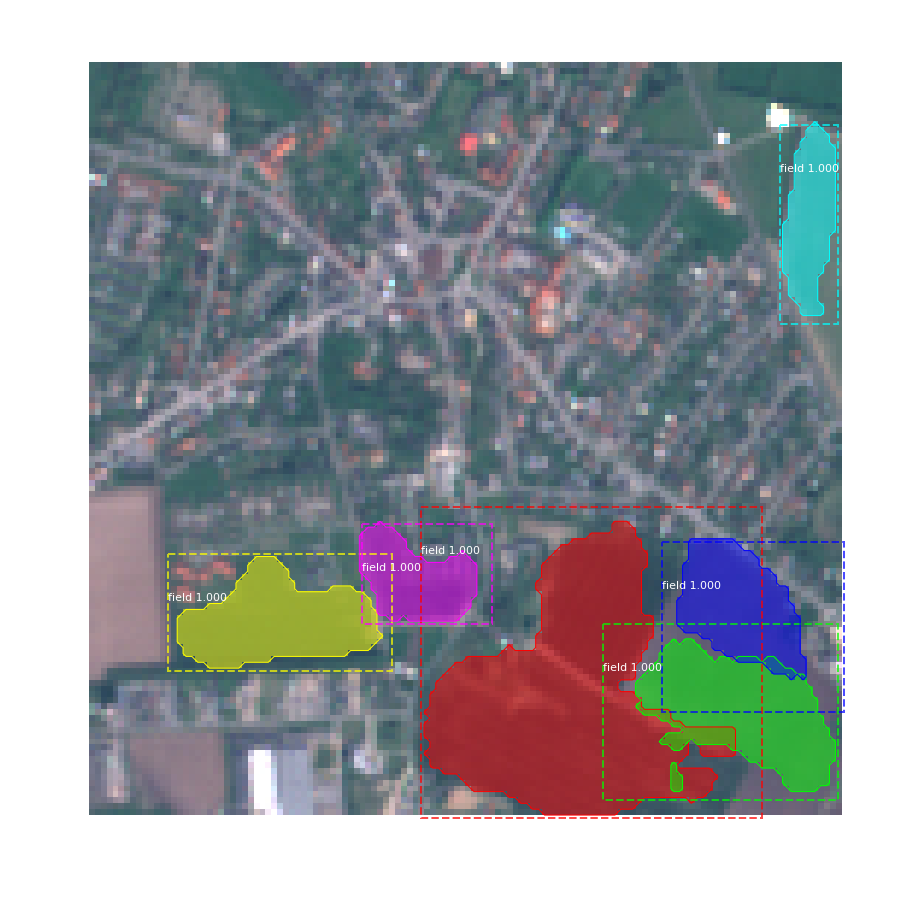

'\nimage_ids = np.random.choice(dataset_train.image_ids, 5)\nprint(image_ids)\nAPs = [] \nfor image_id in image_ids:\n    # Load image and ground truth data\n    image, image_meta, gt_class_id, gt_bbox, gt_mask =        modellib.load_image_gt(dataset_train, config,\n                               image_id, use_mini_mask=False)\n    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)\n    # Run object detection\n    results = model.detect([image], verbose=0)\n    r = results[0]\n    # Compute AP\n    AP, precisions, recalls, overlaps =        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,\n                         r["rois"], r["class_ids"], r["scores"], r[\'masks\'])\n   \n    visualize.display_instances(image,r[\'rois\'], r[\'masks\'], r[\'class_ids\'], \n                            class_names, r[\'scores\'])\n      \n    APs.append(AP)\n  \nprint("mAP: ", np.mean(APs))'

In [0]:
#prediction and result 
import os
import sys
import time
import numpy as np
import skimage.io

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3. 
# A quick one liner to install the library 
# !pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils 

import coco #a slightly modified version

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import ForafricDataset
from mrcnn import visualize


import zipfile
import urllib.request
import shutil
import glob
import tqdm
import random
#------------------------------------------prepare my data location-------------------------------------------------------------------#
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "poids_audricnew5.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "data", "test", "images")
#------------------------------------------------------------------------------------------------------------------------------#
#i intentiate my  configuration
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1+1
    IMAGE_MAX_DIM=128
    IMAGE_MIN_DIM=128
    NAME = "ForAfricPro"
config = InferenceConfig()
config.display()
#--------------------------------------------------------------------------------------------------------------------------------------#
#I initiate my  model 
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model_path = PRETRAINED_MODEL_PATH

# or if you want to use the latest trained model, you can use : 
#model_path = model.find_last()[1]

model.load_weights(model_path, by_name=True)
#----------------------------------------------------------------------------------------------------------------------------------------#
#i run prediction for single image 
class_names = ['BG', 'field'] # In our case, we have 1 class
file_names = next(os.walk(IMAGE_DIR))[2]
print(file_names)
random_image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

predictions = model.detect([random_image]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size
p = predictions[0]
visualize.display_instances(random_image,p['rois'], p['masks'], p['class_ids'], 
                            class_names, p['scores'])

#the follow code is to evaluate the model and compute the average precision 

"""
image_ids = np.random.choice(dataset_val.image_ids, 5)
print(image_ids)
APs = [] 
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
   
    visualize.display_instances(image,r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
      
    APs.append(AP)
  
print("mAP: ", np.mean(APs))"""


# **Plot the precision-recall curve**

[0.6818181872367859, 0.6875, 1.0, 0.7307692170143127, 0.6153846383094788]


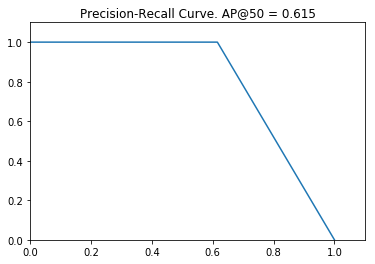

In [0]:

AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

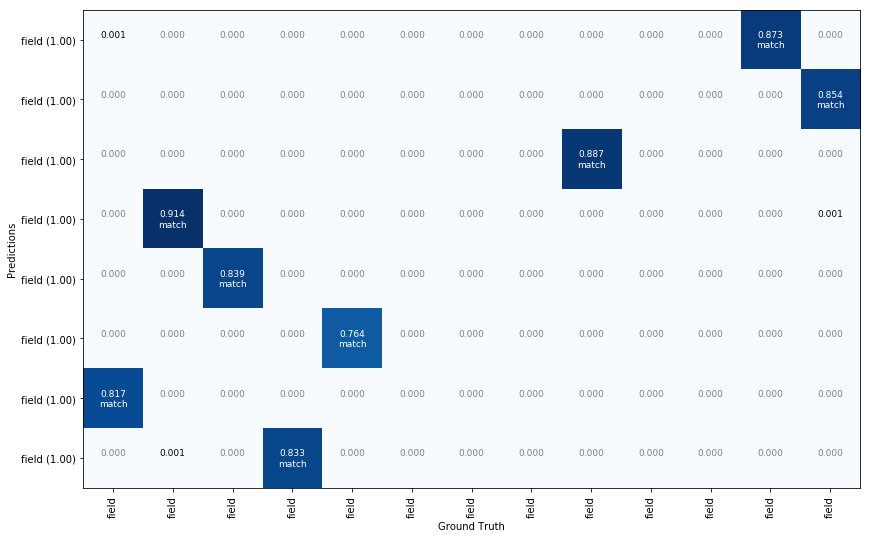

In [0]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, class_names)

# Analyze the model's behavior **texte en gras**

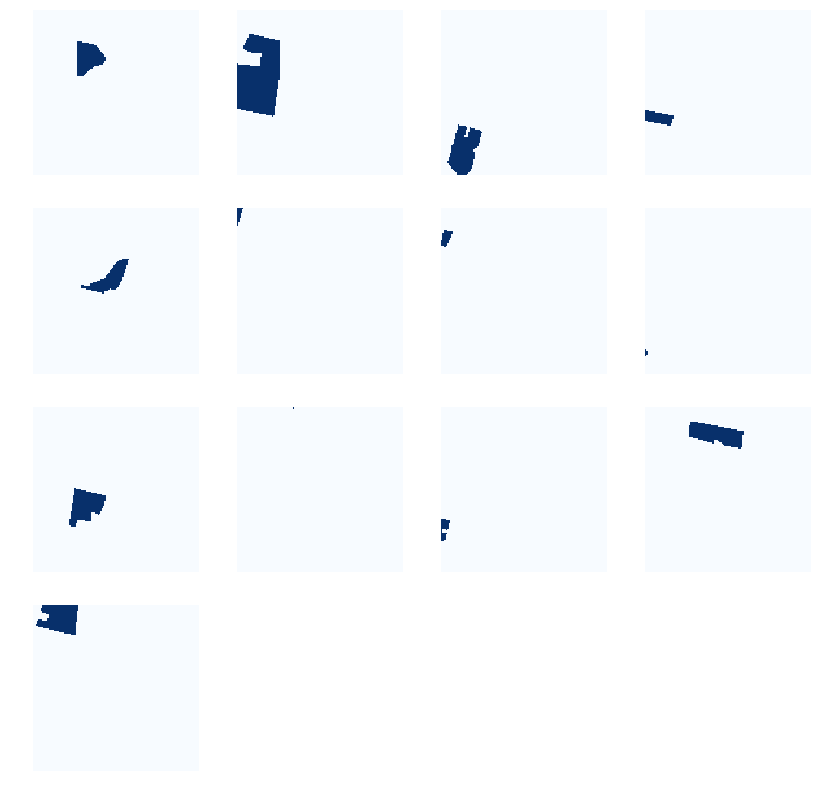

In [0]:
#visualize the field geometric to fit which fit the model
from mrcnn.visualize import display_images
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

In [0]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00001  max:    1.00000  float32
8 detections: ['field' 'field' 'field' 'field' 'field' 'field' 'field' 'field']


In [0]:
# Masks
from mrcnn.model import log
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (8, 28, 28)           min:    0.00001  max:    1.00000  float32
det_masks                shape: (8, 128, 128)         min:    0.00000  max:    1.00000  bool


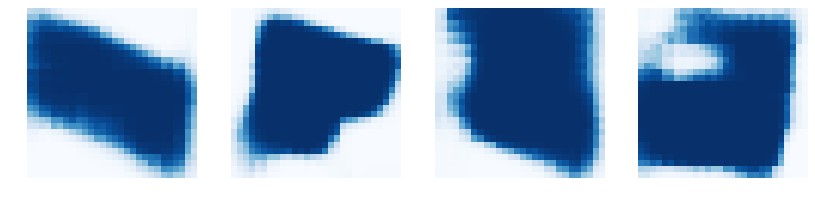

In [0]:
#display the prediction mask 
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

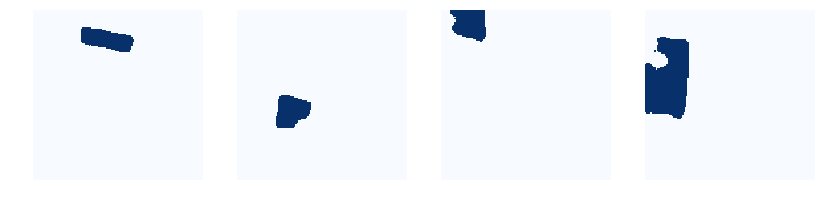

In [0]:

display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

# **Visualize some training phases to debug the model (optional to the code)**

In [0]:
#Visualize Activations
# Get activations of a few sample layers
import tensorflow as tf
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])


input_image              shape: (1, 128, 128, 3)      min:  -85.70000  max:   81.30000  float32
res4w_out                shape: (1, 8, 8, 1024)       min:    0.00000  max:   21.41812  float32
rpn_bbox                 shape: (1, 4092, 4)          min:  -11.74551  max:   26.38470  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


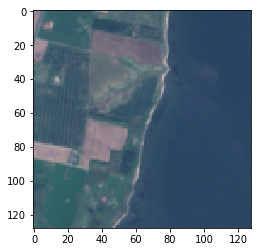

In [0]:
# Input image (normalized)
import matplotlib
import matplotlib.pyplot as plt
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

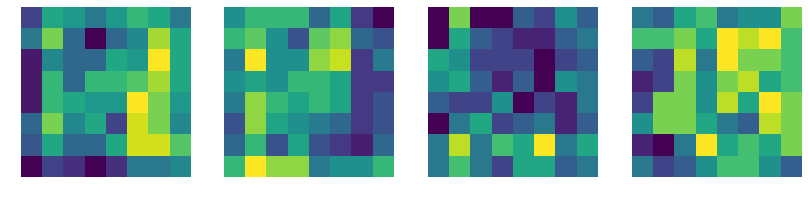

In [0]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

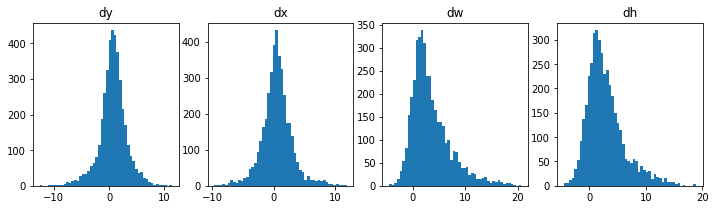

In [0]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

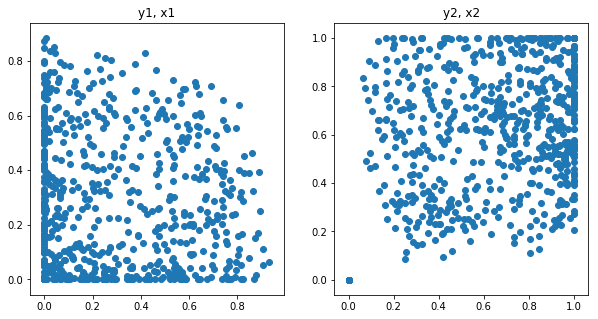

In [0]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()

In [0]:
#review model 
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1_10/kernel:0,"(7, 7, 3, 64)",-0.0672,+0.0637,+0.0257
conv1_10/bias:0,"(64,)",-0.0003,+0.0011,+0.0003
bn_conv1_10/gamma:0,"(64,)",+0.9960,+1.0038,+0.0019
bn_conv1_10/beta:0,"(64,)",-0.0003,+0.0011,+0.0003
bn_conv1_10/moving_mean:0*** dead?,"(64,)",+0.0000,+0.0000,+0.0000
bn_conv1_10/moving_variance:0*** dead?,"(64,)",+1.0000,+1.0000,+0.0000
res2a_branch2a_10/kernel:0,"(1, 1, 64, 64)",-0.2175,+0.2179,+0.1253
res2a_branch2a_10/bias:0,"(64,)",-0.0004,+0.0004,+0.0002
bn2a_branch2a_10/gamma:0,"(64,)",+0.9976,+1.0031,+0.0009
bn2a_branch2a_10/beta:0,"(64,)",-0.0004,+0.0004,+0.0002


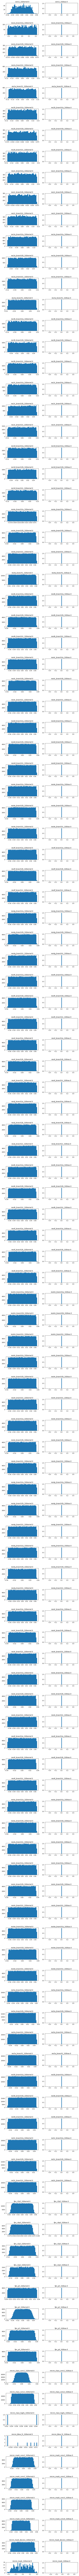

In [0]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)

# Author 

Audric Dongfack (dongfackaudric@gmail.com)